In [1]:
library(Seurat)
library(ggplot2)
library(patchwork)
library(dplyr)
library(arrow)
library(hdf5r)
library(magick)
library(rhdf5)
library(ape)
# library(SeuratWrappers)
library(Banksy)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


The tzdb package is not installed. Timezones will not be available to Arrow compute functions.


Attaching package: 'arrow'


The following object is masked from 'package:utils':

    timestamp


Linking to ImageMagick 6.9.12.98
Enabled features: cairo, freetype, fftw, ghostscript, heic, lcms, pango, raw, rsvg, webp
Disabled features: fontconfig, x11


Attaching package: 'rhdf5'


The following object is masked from 'package:hdf5r':

    h5version



Attaching package: 'ape'


The following object is masked from 'package:dplyr':

    where




In [2]:
localdir <- "sample2/"
object <- Load10X_Spatial(data.dir = localdir, bin.size = c(8, 16))

# Setting default assay changes between 8um and 16um binning
Assays(object)
DefaultAssay(object) <- "Spatial.008um"

[1] "Spatial.008um" "Spatial.016um"

In [3]:
# 获取空间坐标（通常存储在 images 中的 coordinates）
spatial_coords <- GetTissueCoordinates(object, image = "slice1.008um")

# 查看坐标
head(spatial_coords)
# print(object)

,x,y,cell
,<dbl>,<dbl>,<chr>
s_008um_00377_00750-1,35483.77,11053.577,s_008um_00377_00750-1
s_008um_00515_00112-1,16824.84,15156.104,s_008um_00515_00112-1
s_008um_00383_00696-1,33903.99,11234.557,s_008um_00383_00696-1
s_008um_00086_00091-1,16167.02,2601.978,s_008um_00086_00091-1
s_008um_00717_00582-1,30600.81,21020.801,s_008um_00717_00582-1
s_008um_00320_00191-1,19117.50,9440.989,s_008um_00320_00191-1


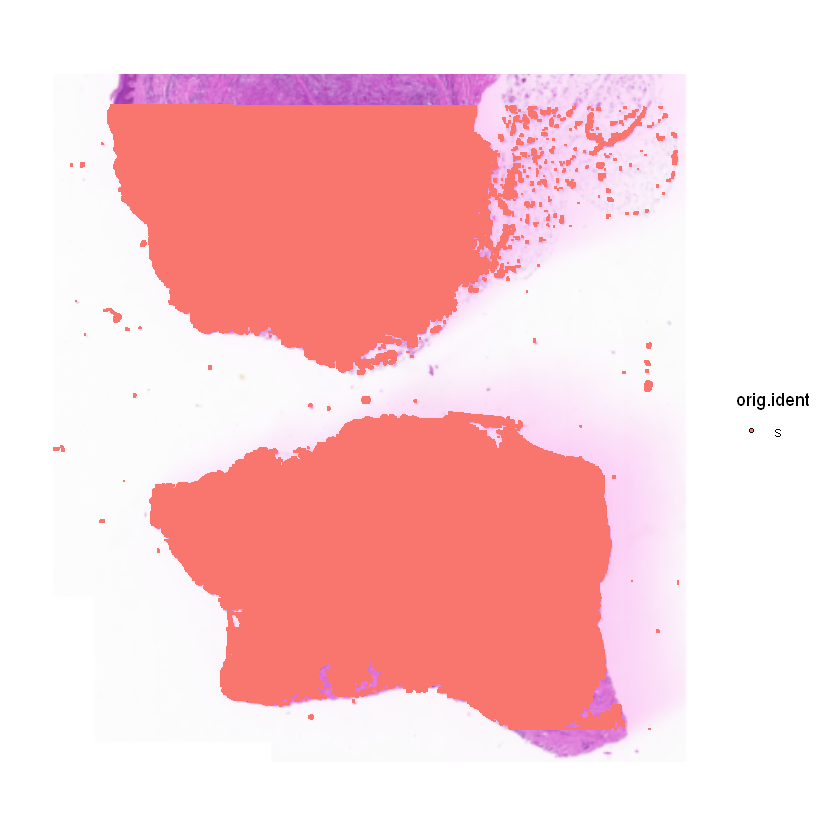

In [4]:
# 可视化空间分布
SpatialDimPlot(object, group.by = "orig.ident")

In [4]:
# 设置 y 轴阈值
x_threshold <- 25000

# 筛选出满足 y 坐标大于阈值的细胞
upper_half_indices <- rownames(spatial_coords)[spatial_coords[, "x"] > x_threshold]

# 使用 subset 函数筛选出这些细胞
object <- subset(object, cells = upper_half_indices)

# 检查筛选后的对象
object


Spatial.016um assay doesn't leave any cells, so it is removed

Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating Seurat objects"
Warning message:
"Not validating Seurat objects"


An object of class Seurat 
18085 features across 193621 samples within 1 assay 
Active assay: Spatial.008um (18085 features, 0 variable features)
 1 layer present: counts
 1 spatial field of view present: slice1.008um

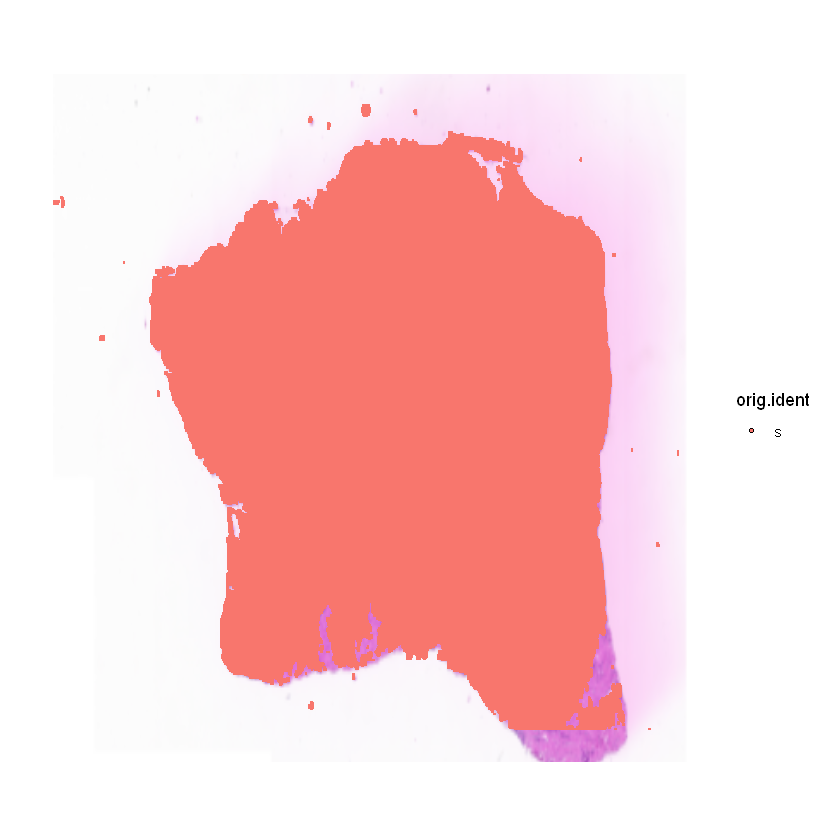

In [6]:
# 可视化空间分布
SpatialDimPlot(object, group.by = "orig.ident")


Warning message:
"Default search for "data" layer in "Spatial.008um" assay yielded no results; utilizing "counts" layer instead."


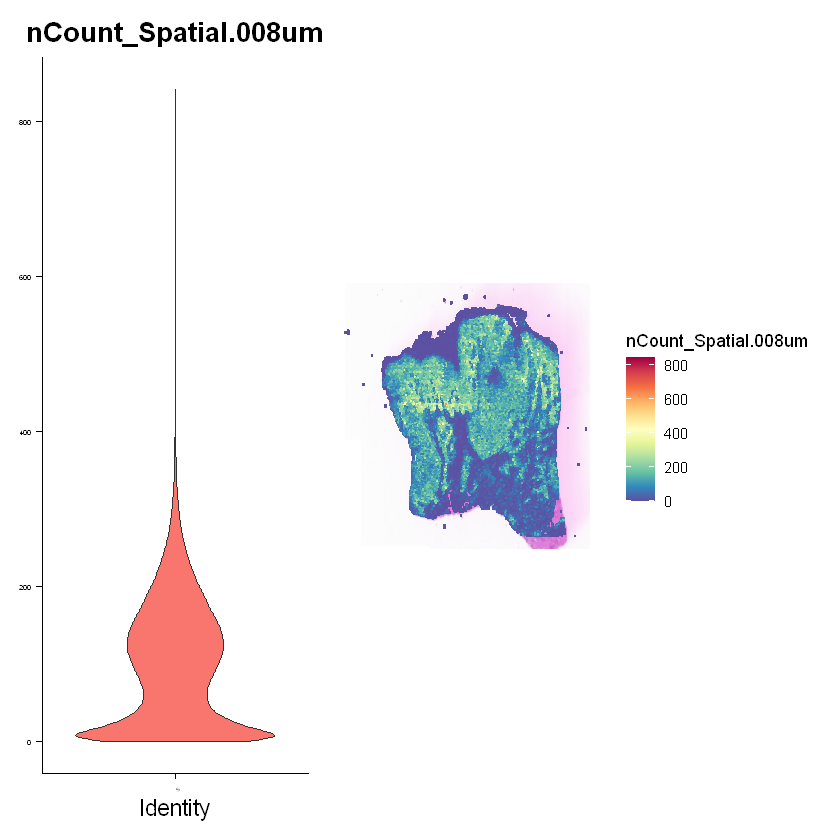

In [5]:
vln.plot <- VlnPlot(object, features = "nCount_Spatial.008um", pt.size = 0) + theme(axis.text = element_text(size = 4)) + NoLegend()
count.plot <- SpatialFeaturePlot(object, features = "nCount_Spatial.008um") + theme(legend.position = "right")

# note that many spots have very few counts, in-part
# due to low cellular density in certain tissue regions
vln.plot | count.plot

In [6]:
# normalize both 8um and 16um bins
DefaultAssay(object) <- "Spatial.008um"
object <- NormalizeData(object)

# DefaultAssay(object) <- "Spatial.016um"
# object <- NormalizeData(object)

Normalizing layer: counts



In [7]:
# note that data is already normalized
DefaultAssay(object) <- "Spatial.008um"
object <- FindVariableFeatures(object)
object <- ScaleData(object)
# we select 50,0000 cells and create a new 'sketch' assay
object <- SketchData(
  object = object,
  ncells = 50000,
  method = "LeverageScore",
  sketched.assay = "sketch"
)

Finding variable features for layer counts

Centering and scaling data matrix

Calcuating Leverage Score

Attempting to cast layer counts to dgCMatrix

Attempting to cast layer data to dgCMatrix



In [8]:
# switch analysis to sketched cells
DefaultAssay(object) <- "sketch"

# perform clustering workflow
object <- FindVariableFeatures(object)
object <- ScaleData(object)
object <- RunPCA(object, assay = "sketch", reduction.name = "pca.sketch")
object <- FindNeighbors(object, assay = "sketch", reduction = "pca.sketch", dims = 1:50)
object <- FindClusters(object, cluster.name = "seurat_cluster.sketched", resolution = 0.4)
object <- RunUMAP(object, reduction = "pca.sketch", reduction.name = "umap.sketch", return.model = T, dims = 1:50)

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  COL1A1, IGKC, CXCL9, APOE, IGHG1, CXCL10, CLU, CXCL13, COL4A1, COL4A2 
	   CYBB, MS4A1, IGHA1, A2M, CXCL12, TIMP1, IGFBP7, CD163, ENG, IDO1 
	   CCL19, CCDC80, STAB1, COMP, TAGLN, AQP1, ACTA2, C3, COL12A1, DST 
Negative:  CNFN, SBSN, LCE3D, SPRR2G, KRTDAP, SPRR2E, CDSN, SPRR1B, ASPRV1, CSTA 
	   FLG, CALML5, SPRR2D, LOR, HRNR, PI3, SLURP1, KRT6B, FLG2, SPRR2A 
	   KRT80, CRCT1, SLURP2, WFDC12, KRT17, AZGP1, NCCRP1, CPA4, LCE2C, KRT10 
PC_ 2 
Positive:  LOR, LCE2C, LCE1C, AZGP1, ASPRV1, FLG2, LCE1A, FLG, C1orf68, WFDC12 
	   KPRP, HRNR, LCE6A, LCE3D, CPA4, LCE2A, HAL, ARG1, LCE2B, SPRR2G 
	   LCE3E, SPRR5, ACP7, BNIP3L, YOD1, PSORS1C2, CDSN, COL1A1, ATP6V1C2, LCE1B 
Negative:  KRT6B, KRT6C, SPRR1B, KRT17, FABP5, PI3, DSG1, SLPI, KRT5, CALML3 
	   CSTA, AQP3, KRTDAP, RHCG, SPRR2A, EPGN, ANXA1, SPRR2D, S100A2, TGM1 
	   IVL, CDH3, C10orf99, GJA1, SBSN, TUBB2A, DEFB1, S100A7A, KLK13, SLC6A14 
P

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 50000
Number of edges: 2332857

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9168
Number of communities: 29
Elapsed time: 14 seconds


1 singletons identified. 28 final clusters.

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
UMAP will return its model

11:25:44 UMAP embedding parameters a = 0.9922 b = 1.112

11:25:44 Read 50000 rows and found 50 numeric columns

11:25:44 Using Annoy for neighbor search, n_neighbors = 30

11:25:44 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:25:52 Writing NN index file to temp file C:\Users\kdy12\AppData\Local\Temp\RtmpkPlyfR\file35d41aeb28ec

11:25:52 Searching Annoy index using 1 thread, search_k = 3000

11:26:11 Annoy recal

In [9]:
object <- ProjectData(
  object = object,
  assay = "Spatial.008um",
  full.reduction = "full.pca.sketch",
  sketched.assay = "sketch",
  sketched.reduction = "pca.sketch",
  umap.model = "umap.sketch",
  dims = 1:50,
  refdata = list(seurat_cluster.projected = "seurat_cluster.sketched")
)

full.pca.sketch is not in the object. Data from all cells will be projected to pca.sketch

Projecting cell embeddings



Finding sketch neighbors

Finding sketch weight matrix

Transfering refdata from sketch

Projection to sketch umap

Running UMAP projection

11:29:14 Read 193621 rows

11:29:14 Processing block 1 of 1

11:29:14 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

11:29:16 19972 smooth knn distance failures

11:29:17 Initializing by weighted average of neighbor coordinates using 1 thread

11:29:17 Commencing optimization for 67 epochs, with 5754510 positive edges

11:30:13 Finished

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from full.umap.sketch to fullumapsketch_"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



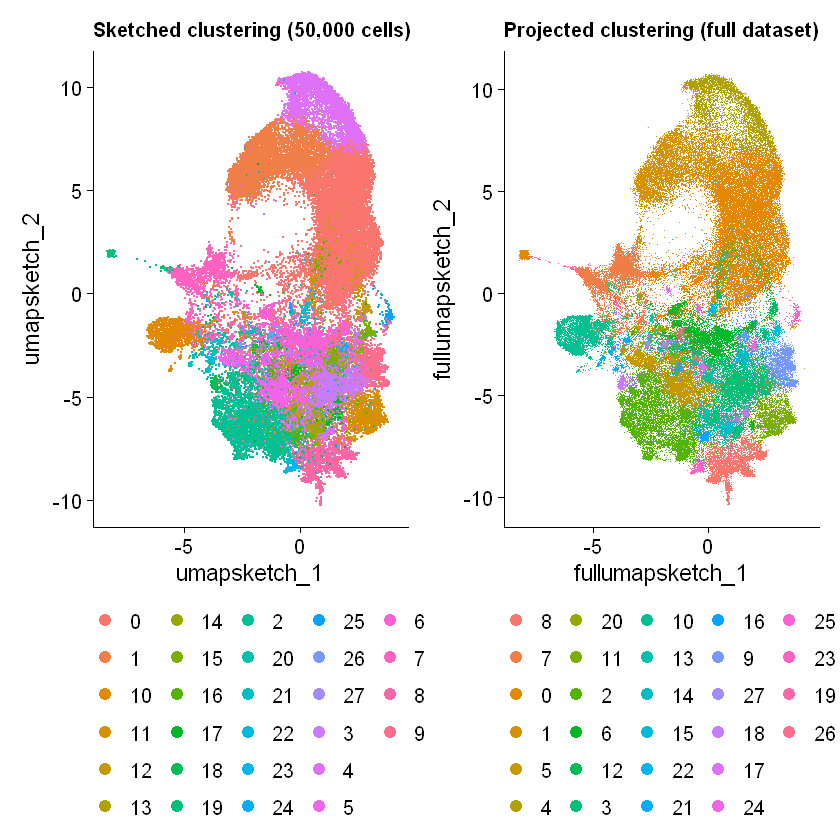

In [10]:
DefaultAssay(object) <- "sketch"
Idents(object) <- "seurat_cluster.sketched"
p1 <- DimPlot(object, reduction = "umap.sketch", label = F) + ggtitle("Sketched clustering (50,000 cells)") + theme(legend.position = "bottom")

# switch to full dataset
DefaultAssay(object) <- "Spatial.008um"
Idents(object) <- "seurat_cluster.projected"
p2 <- DimPlot(object, reduction = "full.umap.sketch", label = F) + ggtitle("Projected clustering (full dataset)") + theme(legend.position = "bottom")


p1 <- p1 + theme(plot.title = element_text(size = 12))
p2 <- p2 + theme(plot.title = element_text(size = 12))
p1 | p2

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
"ggrepel: 14 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


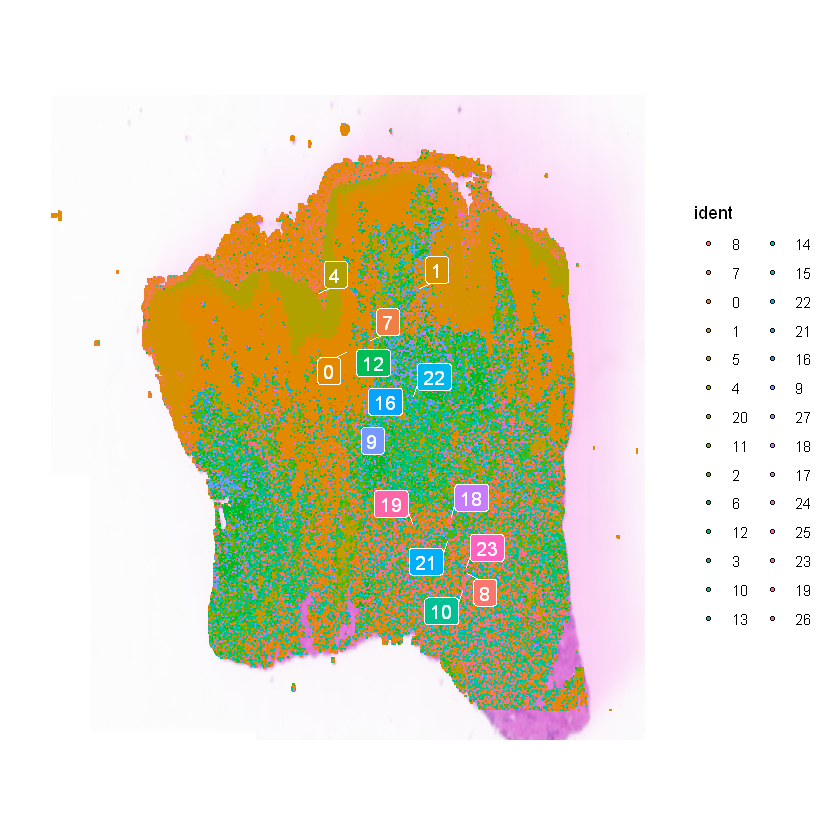

In [21]:
SpatialDimPlot(object, label = T, repel = T, label.size = 4)

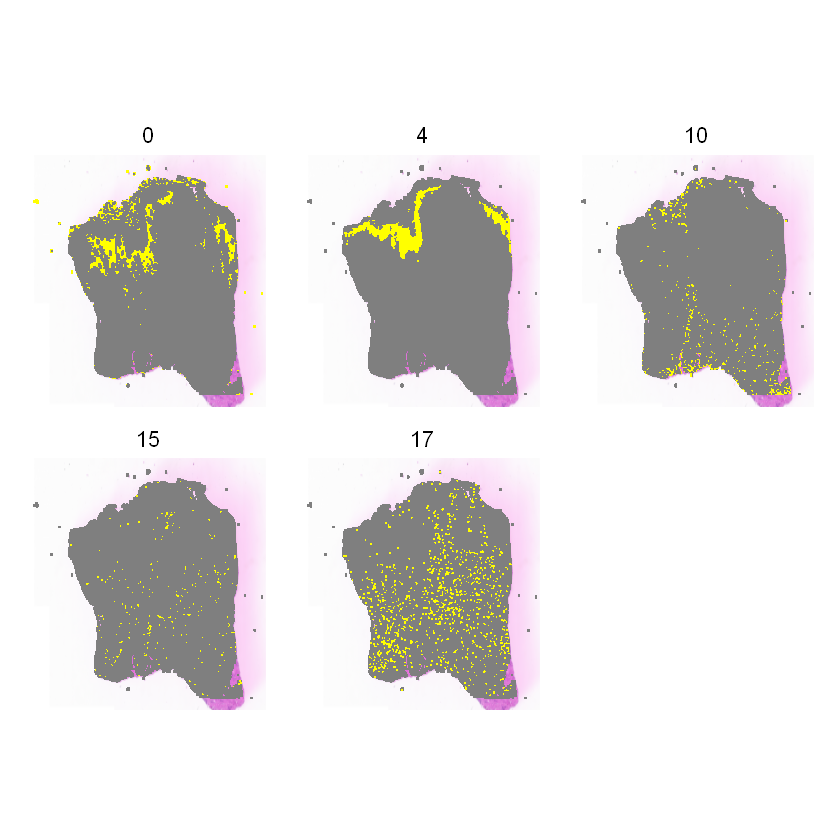

In [22]:
Idents(object) <- "seurat_cluster.projected"
cells <- CellsByIdentities(object, idents = c(0, 4, 10, 15, 17))
p <- SpatialDimPlot(object,
  cells.highlight = cells[setdiff(names(cells), "NA")],
  cols.highlight = c("#FFFF00", "grey50"), facet.highlight = T, combine = T
) + NoLegend()
p

Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating Seurat objects"
Reordering identity classes and rebuilding tree

Calculating cluster 5

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 7

Ca

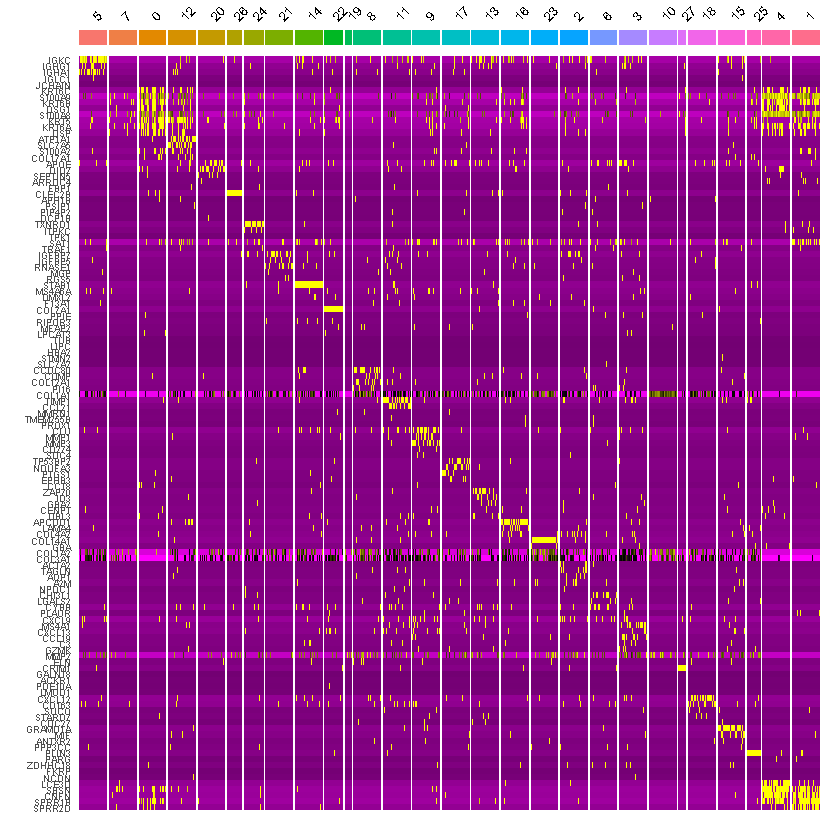

In [11]:
# Crete downsampled object to make visualization either
DefaultAssay(object) <- "Spatial.008um"
Idents(object) <- "seurat_cluster.projected"
object_subset <- subset(object, cells = Cells(object[["Spatial.008um"]]), downsample = 1000)

# Order clusters by similarity
DefaultAssay(object_subset) <- "Spatial.008um"
Idents(object_subset) <- "seurat_cluster.projected"
object_subset <- BuildClusterTree(object_subset, assay = "Spatial.008um", reduction = "full.pca.sketch", reorder = T)

markers <- FindAllMarkers(object_subset, assay = "Spatial.008um", only.pos = TRUE)
markers %>%
  group_by(cluster) %>%
  dplyr::filter(avg_log2FC > 1) %>%
  slice_head(n = 5) %>%
  ungroup() -> top5

object_subset <- ScaleData(object_subset, assay = "Spatial.008um", features = top5$gene)
p <- DoHeatmap(object_subset, assay = "Spatial.008um", features = top5$gene, size = 2.5) + theme(axis.text = element_text(size = 5.5)) + NoLegend()
p

In [31]:
# BiocManager::install('Banksy')
remotes::install_github("prabhakarlab/Banksy@legacy")
library(Banksy)

iterators    (NA -> 1.0.14 ) [CRAN]
maps         (NA -> 3.4.2  ) [CRAN]
foreach      (NA -> 1.5.2  ) [CRAN]
GlobalOpt... (NA -> 0.1.2  ) [CRAN]
shape        (NA -> 1.4.6.1) [CRAN]
prettyunits  (NA -> 1.2.0  ) [CRAN]
hms          (NA -> 1.1.3  ) [CRAN]
mapproj      (NA -> 1.2.11 ) [CRAN]
dichromat    (NA -> 2.0-0.1) [CRAN]
doParallel   (NA -> 1.0.17 ) [CRAN]
clue         (NA -> 0.3-65 ) [CRAN]
GetoptLong   (NA -> 1.0.5  ) [CRAN]
circlize     (NA -> 0.4.16 ) [CRAN]
progress     (NA -> 1.2.3  ) [CRAN]
pals         (NA -> 1.9    ) [CRAN]
ggalluvial   (NA -> 0.12.5 ) [CRAN]
ComplexHe... (NA -> 2.18.0 ) [CRAN]


Skipping 14 packages ahead of CRAN: zlibbioc, XVector, SparseArray, S4Arrays, IRanges, S4Vectors, MatrixGenerics, BiocGenerics, GenomeInfoDbData, GenomeInfoDb, DelayedArray, Biobase, GenomicRanges, SummarizedExperiment

Installing 17 packages: iterators, maps, foreach, GlobalOptions, shape, prettyunits, hms, mapproj, dichromat, doParallel, clue, GetoptLong, circlize, progress, pals, ggalluvial, ComplexHeatmap

Warning message:
"unable to access index for repository https://bioconductor.org/packages/3.18/bioc/bin/windows/contrib/4.4:
  cannot open URL 'https://bioconductor.org/packages/3.18/bioc/bin/windows/contrib/4.4/PACKAGES'"
Warning message:
"unable to access index for repository https://bioconductor.org/packages/3.18/data/annotation/bin/windows/contrib/4.4:
  cannot open URL 'https://bioconductor.org/packages/3.18/data/annotation/bin/windows/contrib/4.4/PACKAGES'"
Warning message:
"unable to access index for repository https://bioconductor.org/packages/3.18/data/experiment/bin/win

package 'iterators' successfully unpacked and MD5 sums checked
package 'maps' successfully unpacked and MD5 sums checked
package 'foreach' successfully unpacked and MD5 sums checked
package 'GlobalOptions' successfully unpacked and MD5 sums checked
package 'shape' successfully unpacked and MD5 sums checked
package 'prettyunits' successfully unpacked and MD5 sums checked
package 'hms' successfully unpacked and MD5 sums checked
package 'mapproj' successfully unpacked and MD5 sums checked
package 'dichromat' successfully unpacked and MD5 sums checked
package 'doParallel' successfully unpacked and MD5 sums checked
package 'clue' successfully unpacked and MD5 sums checked
package 'GetoptLong' successfully unpacked and MD5 sums checked
package 'circlize' successfully unpacked and MD5 sums checked
package 'progress' successfully unpacked and MD5 sums checked
package 'pals' successfully unpacked and MD5 sums checked
package 'ggalluvial' successfully unpacked and MD5 sums checked

The downloade

installing the source package 'ComplexHeatmap'




── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file 'C:\Users\kdy12\AppData\Local\Temp\RtmpkPlyfR\remotes35d47a2425e8\prabhakarlab-Banksy-6130b3d/DESCRIPTION' ... OK
* preparing 'Banksy':
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* looking to see if a 'data/datalist' file should be added
* building 'Banksy_0.1.6.tar.gz'



Warning message:
"package 'Banksy' is in use and will not be installed"


In [1]:
   sessionInfo()

R version 4.4.1 (2024-06-14 ucrt)
Platform: x86_64-w64-mingw32/x64
Running under: Windows 11 x64 (build 22631)

Matrix products: default


locale:
[1] LC_COLLATE=Chinese (Simplified)_China.utf8 
[2] LC_CTYPE=Chinese (Simplified)_China.utf8   
[3] LC_MONETARY=Chinese (Simplified)_China.utf8
[4] LC_NUMERIC=C                               
[5] LC_TIME=Chinese (Simplified)_China.utf8    

time zone: Asia/Shanghai
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] digest_0.6.37     IRdisplay_1.1     utf8_1.2.4        base64enc_0.1-3  
 [5] fastmap_1.2.0     glue_1.7.0        htmltools_0.5.8.1 repr_1.1.7       
 [9] lifecycle_1.0.4   cli_3.6.3         fansi_1.0.6       vctrs_0.6.5      
[13] pbdZMQ_0.3-13     compiler_4.4.1    tools_4.4.1       evaluate_1.0.0   
[17] pillar_1.9.0      crayon_1.5.3      rlang_1.1.4       jsonlite_1.8.9   
[21] IRkernel_1.3.2    uuid_1.2-1  

In [34]:
object <- Banksy::RunBanksy(object,
  lambda = 0.8, verbose = TRUE,
  assay = "Spatial.008um", slot = "data", features = "variable",
  k_geom = 50
)

ERROR: Error: 'RunBanksy' is not an exported object from 'namespace:Banksy'


In [11]:
# BiocManager::install("SeuratWrappers")
remotes::install_github('satijalab/seurat-wrappers')

Error in utils::download.file(url, path, method = method, quiet = quiet,  : 
  download from 'https://api.github.com/repos/satijalab/seurat-wrappers/tarball/HEAD' failed


In [18]:
# library(seurat-wrappers)
library(Banksy)